# Ridge Regression Multi Variable - v.Workshop#  


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime

%matplotlib inline

In [59]:
# Import data from previous results and create DataFrame objects
Weather = pd.read_csv('weather_hourly_boston.csv', sep=',')
Rents = pd.read_csv('KPI_total_rents_per_hour.csv', sep=',')
df_rents = pd.DataFrame(Rents)
df_weather = pd.DataFrame(Weather)

# Clean the weather dataset and get data for 2019 only
df_weather = df_weather.dropna()
begin_2019 = pd.to_datetime('2019-01-01 00:00')
end_2019 = pd.to_datetime('2019-12-31 23:00')
times = pd.to_datetime(df_weather.date_time)
df_weather_2019 = df_weather.loc[(times.dt.year >= 2019) & (times.dt.year <= 2019)]
df_weather_2019 = df_weather_2019.reset_index()
df_weather_2019 = df_weather_2019.set_index('date_time')

# Create the combined dataset. Do a left-join on weather dataset timestamps.
df_weather_2019.index = df_weather_2019.index.rename('hour')
df_weather_and_rents = pd.merge(df_weather_2019,df_rents,on='hour',how='left')
df_weather_and_rents = df_weather_and_rents.drop_duplicates(subset=['hour'], keep='first')
df_weather_and_rents = df_weather_and_rents.dropna()
df_weather_and_rents = df_weather_and_rents.sort_values(by=['hour'])
df_weather_and_rents = df_weather_and_rents.drop('index', axis='columns')
df_weather_and_rents['avg_temp'] = (df_weather_and_rents['max_temp'] + df_weather_and_rents['min_temp'])/2
df_weather_and_rents = df_weather_and_rents.drop(['min_temp','max_temp'], axis='columns')

df_weather_and_rents['datetime'] = df_weather_and_rents['hour']
df_weather_and_rents.drop('hour', axis = 1)



#prepare the data
df = pd.DataFrame(df_weather_and_rents['datetime'])

times = pd.to_datetime(df.datetime)
dailyData = pd.DataFrame(times)
dailyData["hour"] = times.dt.hour
dailyData["weekday"] = times.dt.weekday
dailyData["month"] = times.dt.month
df_weather_and_rents['hour'] = dailyData['hour']
df_weather_and_rents['weekday'] = dailyData['weekday']
df_weather_and_rents['month'] = dailyData['month']

In [60]:
df_weather_and_rents

,hour,precip,rents_count,avg_temp,datetime,weekday,month
5,0,1.0,7.0,5.6,2019-01-01 00:00:00,1,1
0,1,1.0,24.0,3.9,2019-01-01 01:00:00,1,1
1,2,1.0,5.0,3.3,2019-01-01 02:00:00,1,1
2,3,1.0,3.0,2.8,2019-01-01 03:00:00,1,1
4,4,1.0,1.0,3.6,2019-01-01 04:00:00,1,1
...,...,...,...,...,...,...,...
8682,19,0.0,100.0,3.9,2019-12-31 19:00:00,1,12
8683,20,0.0,57.0,3.3,2019-12-31 20:00:00,1,12
8684,21,1.0,48.0,3.3,2019-12-31 21:00:00,1,12
8685,22,0.0,40.0,3.3,2019-12-31 22:00:00,1,12


In [4]:
df_weather_and_rents = df_weather_and_rents.drop('datetime',axis = 1)
df_weather_and_rents

,hour,precip,rents_count,avg_temp,weekday,month
5,0,1.0,7.0,5.6,1,1
0,1,1.0,24.0,3.9,1,1
1,2,1.0,5.0,3.3,1,1
2,3,1.0,3.0,2.8,1,1
4,4,1.0,1.0,3.6,1,1
...,...,...,...,...,...,...
8682,19,0.0,100.0,3.9,1,12
8683,20,0.0,57.0,3.3,1,12
8684,21,1.0,48.0,3.3,1,12
8685,22,0.0,40.0,3.3,1,12


In [5]:
#Separate train and test data. 
train, test = train_test_split(df_weather_and_rents, test_size = 0.7, random_state = 10)
train.info()

#Assign train target value(y)
y = train['rents_count']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2447 entries, 7098 to 1403
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hour         2447 non-null   int64  
 1   precip       2447 non-null   float64
 2   rents_count  2447 non-null   float64
 3   avg_temp     2447 non-null   float64
 4   weekday      2447 non-null   int64  
 5   month        2447 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 133.8 KB


In [14]:
xp = train.drop('rents_count', axis=1).values
print(xp)
yp = y.values

[[ 1.   0.  11.1  6.  10. ]
 [10.   0.  10.   3.   5. ]
 [11.   1.  20.   1.   6. ]
 ...
 [ 8.   0.  20.6  6.   7. ]
 [ 6.   0.   2.8  5.  11. ]
 [20.   0.  -0.6  3.   2. ]]


In [53]:
from sklearn.preprocessing import PolynomialFeatures

# initialize model
Poly = PolynomialFeatures(degree = 4)

# fit and transform xp
X_poly = Poly.fit_transform(xp.reshape(-1,1))

In [54]:
#len(X_poly)

In [56]:
from sklearn.linear_model import Ridge

model_L2 = Ridge(alpha = 0.01, normalize = True, solver = 'lsqr')

model_L2.fit(X_poly, yp)
prediction = model_L2.predict(X_poly)

print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )
print(prediction)

ValueError: Found input variables with inconsistent numbers of samples: [12235, 2447]

(-88.4, 1878.4)

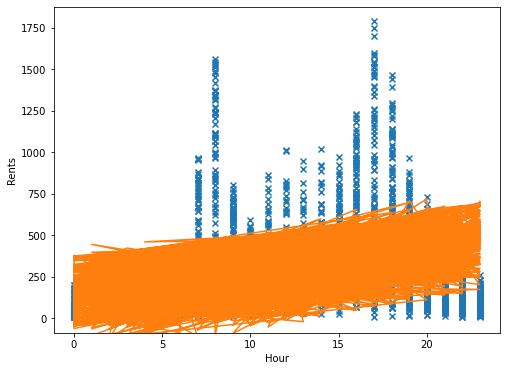

In [57]:
plt.figure(figsize = (8,6))
plt.scatter(train['hour'], yp, marker="x")
ylim = plt.ylim()
plt.plot(train['hour'], prediction, 'C1')
plt.xlabel("Hour")
plt.ylabel("Rents")
plt.ylim(ylim)

In [49]:
# function for plotting

def plot_scikit_output (x, y, fitted_model):
    
    min_x, max_x = x.min(), x.max()
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    
    xt0_poly = Poly.fit_transform(xt0.reshape(-1,1))
    
    # plotting routine
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, fitted_model.predict(xt0_poly), 'C1')
    plt.xlabel("Hour")
    plt.ylabel("Rents")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)

ValueError: x and y must be the same size

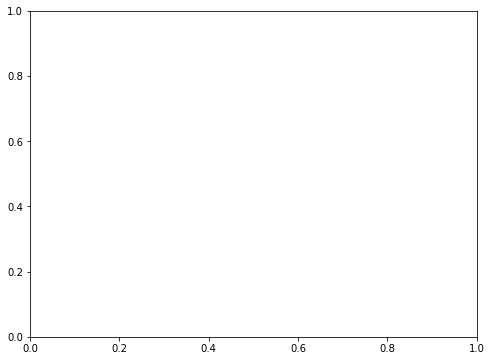

In [51]:
plot_scikit_output (train['hour'], yp, model_L2)

In [356]:
def plot_L2_regression_performance (x, y, deg):

    err_train = []
    err_cv = []
    
    x_train, x_test, y_train, y_test = train_test_split(xp, yp, test_size=0.3,random_state=10)

    for alpha in np.logspace(-15,10,100):

        # create poly features
        poly_reg = PolynomialFeatures (degree = deg)
        X_train_poly = poly_reg.fit_transform(x_train.reshape(-1,1))
        X_test_poly = poly_reg.fit_transform(x_test.reshape(-1,1))

        # fit model
        model_L2 = Ridge(alpha = alpha, normalize = True, solver = 'lsqr') # select least squares regression as solver
        model_L2.fit(X_train_poly, y_train)
    
        # compute errors
        err_train.append(mean_squared_error(model_L2.predict(X_train_poly), y_train))
        err_cv.append(mean_squared_error(model_L2.predict(X_test_poly), y_test))


    plt.figure(figsize = (8,6))
    plt.loglog(np.logspace(-15,10,100), err_train, np.logspace(-15,10,100), err_cv)
    plt.legend(["Training", "Validation"])
    plt.xlabel("$\lambda$ (or alpha in scikit learn terms)")
    plt.ylabel("Mean squared error")
    plt.show()

In [309]:
plot_L2_regression_performance(xp,yp,75)

ValueError: Found input variables with inconsistent numbers of samples: [34260, 5710]

---